# LINEAR MODELING USING THE _F_ DISTRIBUTION

>by Dr Juan H Klopper

- Research Fellow
- School for Data Science and Computational Thinking
- Stellenbosch University

## INTRODUCTION

One of the most useful distributions is the F distribution, which we will use in this notebook.

Linear regression, _t_ tests, and analysis of variance (ANOVA) are often used in the statistical analysis of data. __Linear regression__ creates a model from numerical variables. This model predicts the value of a dependent variable based on one or more independent variables. A _t_ __test__ compares the means of a numerical variable between two sets of observations, and __ANOVA__ can be used to compare the means of a numerical variable between more than two groups.

In this notebook, we explore these statistical methods, both by using simulations and resampling, as well as using formal statistical tests. We look at how to create a simple linear model and evaluate its interpretation., with repsect to the coefficient of determination, $R^{2}$, and the calculation of a _p_ value based on the _F_ distribution.

We also explore the use of the _F_ distribution in _t_ tests an in ANOVA. If some of these concepts are unknown to you, then this tutorial is for you.

## PACKAGES USED IN THIS NOTEBOOK

The following packages will be used in this notebook.

In [ ]:
import numpy as np
from scipy import stats
from scipy import special
from pandas import DataFrame

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = 'plotly_white'

Some of the models that we will create require the data to be in a specific format. The patsy package is excellent for data formatting. The statsmodels package provides functions with which we will build our models.

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm

## CORRELATION

We start to build some intuition about the change in one numerical variable given a change in another numerical variable. In this case, we have a pair of values for each subject in a sample. One of the variables is termed the __independent variable__ and the other the __dependent variable__.

Below, we create a single independent and a single dependent variable. The former takes $50$ samples from a __uniform distribution__ on the interval $\left[ 80, 100 \right]$. To generate the dependent variable, we add some random noise to each value in the independent variable. This random noise is taken from a normal distribution with a mean of $0$ and a standard deviation of $5$. We also use the numpy `round` function and set its last argument value to `1` to indicate that we want rounding to a single decimal place.

In [ ]:
np.random.seed(7) # For reproducible results

# Generate two numpy arrays
independent = np.round(np.random.uniform(low=80, high=100, size=50), 1)
dependent = np.round(independent + np.random.normal(0, 5, 50), 1)

A scatter plot, where each marker (dot) represent the value for each variable is shown below. The independent variable is on the horisontal axis and the dependent variable is on the vertical axis.

In [ ]:
go.Figure(data=go.Scatter(x=independent, y=dependent,
    mode='markers',
    marker=dict(size=12))).update_layout(title='Data',
        yaxis=dict(title='Dependent variable'),
        xaxis=dict(title='Independent variable'))

We can clearly see that for any given subject the dependent variable value is higher if the independent variable is higher. There is some _correlation_ between the two variables, i.e. as one changes so does the other.

We start by considering the variance in each of the two variables. Remeber that the variance is the average squared difference between each variable value and the mean for that variable, shown in (1) for a variable $X$, its data values $x_{i}$, its mean $\bar{x}$, and it sample size $n$. Remember that this is the equation for a sample variance and that for a population variance, we divided by the sample size only.

$$\text{var}\left( X \right) = \frac{\sum_{i=1}^{n}{{\left( x_{i} - \bar{x} \right)}^{2}}}{n - 1} \tag{1}$$

The numpy `sum` function sums over the squares of all the differences. We use it below and then divide by the sample size less $1$.

In [ ]:
np.sum((independent - np.mean(independent))**2) / (len(independent) - 1)

The numpy `var` function calculates this variance for us. The `ddof` is the degrees of freedom. Since we only have one set of values (a single group in our sample), it is set to `1`.

In [ ]:
np.var(independent, ddof=1)

The variance of the `dependent` variable is calculated below.

In [ ]:
np.var(dependent, ddof=1)

__Covariance__ is a measure of the variance between two variables, $X$ (independent variable) and $Y$ (dependent variable) _combined_, shown in (2).

$$\text{cov} \left( X,Y \right) = \frac{\sum_{i=1}^{n}{\left( x_{i} - \bar{x} \right) \left( y_{i} - \bar{y} \right)}}{n} \tag{2}$$

The numpu `cov` function returns a $2 \times 2$ covariance matrix. The top left and bottom right entries shows the sample variance for each variable individually and the other two entries (same value) is the covariance.

In [ ]:
np.cov(independent, dependent)

We note the $27.3$ and the $51.6$ which were the variances of the independent and the dependent variables. The covariance is then $26.9$.

We can use indexing to extract only the covariance.

In [ ]:
np.cov(independent, dependent)[0, 1]

Covariance gives us an idea of the _direction_ of the relationship between the two variables. If the covariance is positive, it indicates a positive relationship. This means as the values of one variable increases, so does the other. If the covariance is negative, then the values of one changes _in the opposite direction_.

__Correlation__ is the _strength of the linear connection or relationship_ between two numerical variables. Correlation is expressed as a __Pearson correlation coefficient__, denoted by $r$, and shown in (3), where $s_{X}$ and $s_{Y}$ are the sample standard deviations of the two variables (independent and dependent in this case).

$$r = \frac{\text{cov} \left( X,Y \right)}{s_{X} s_{Y}} \tag{3}$$

We follow (3) to calculate the correlation.

In [ ]:
np.cov(independent, dependent)[0, 1] / (np.std(independent, ddof=1) * np.std(dependent, ddof=1))

The `pearsonr` function from the stats module of the scipy package returns $r$ and the _p_ value for $r$.

In [ ]:
r, p = stats.pearsonr(
    independent,
    dependent
)

r # Pearson correlation coefficient

In [ ]:
p # p value

Note that the solution is $0.000000005$. This is simply $0$.

The correlation coefficient is on the interval $\left[ -1,+1 \right]$. Note that $-1$ reflects absolute negative correlation (a perfect, in-step decrease in the dependent variable as the independent variable increases). A value of $+1$ reflects an absolute positive correlation (a perfect, in-step increase in the dependent variable as the independent variable increases).

### PROBABILITY OF THE CORRELATION COEFFICIENT

We can use similar principles used in our last notebooks to simulate multiple experiments to calculate a sampling distribution of correlation coefficients and a _p_ value.

Under the null hypothesis there is no correlation between the two variables. We can _shuffle_ the values in the pairs.

Note that the numpy `shuffle` function only shuffles the array in place and we loose the original data. Instead we simply use the `choice` function without replacement. We do so below for $5000$ repeat experiments.

In [ ]:
r_vals_0 = []

# Generating 5000 r values
for i in range(5000):
  r_vals_0.append(np.corrcoef(np.random.choice(independent, size=50, replace=False),
                              np.random.choice(dependent, size=50, replace=False))[0, 1])

We view the sampling distribution of the $r$ values and the $r$ value from our original data.

In [ ]:
ff.create_distplot(
    [r_vals_0],
    ['Correlation coefficients under the null hypothesis'],
    curve_type='normal'
).add_trace(
    go.Scatter(
        x=[r, r],
        y=[0, 1.5],
        name='Correlation coefficient'
    )
).update_layout(
    title='Sampling distribution of correlation coefficients under the null hypothesis',
    xaxis=dict(title='Null hypothesis r values'),
    yaxis=dict({'title':'Density'})
)

To calculate the probability of our $r$ value, we consider the fraction of simulated $r$ values that are greater than the $r$ value for our given data.

In [ ]:
r # Pearson correlation coefficient

In [ ]:
# Fraction of simulated r values larger than r from data
np.sum(np.array(r_vals_0) > r) / len(r_vals_0)

None of the simulated $r$ values is greater than the $r$ value from our original data, hence the small (zero in this casse) _p_ value. This is in keeping with the _p_ value form the `pearsonr` function.

### UNCERTAINTY IN THE CORRELATION COEFFICIENT

Next, we use bootstrap resampling of data pairs to calculate a confidence interval (the uncertainty given our sample). First, we use the numpy `stack` function to combine the pairs of variable values for resampling.

In [ ]:
data = np.stack([independent, dependent], axis=1)
data # View the result of the stack function

We see that the `stack` function generates a list of lists, with each sub list now a pair of values for each observation in our data set.

Bootstrap resampling selects $50$ pairs with replacement and calculates a $r$ value at each resample.

In [ ]:
r_vals_boot = [np.corrcoef(data[np.random.randint(data.shape[0], size=50), :], rowvar=False)[0, 1] for i in range(2000)]

Placing all the bootstrapped $r$ values in order, we can calculate which index in this order will represents the $2.5$% percentile and which the $97.5$% percentle (for a $95$% confidence level).

In [ ]:
2.5 / 100 * 2000 # Lower level index for sample size

In [ ]:
97.5 / 100 * 2000 # Upper level index for sample size

Our original Pearson correlation is shown again below.

In [ ]:
r

The lower bound of the $95$% confidence interval is the value with index $49$.

In [ ]:
lower = np.sort(r_vals_boot)[49]
lower

The upper bound of the $95$% confidence interval is the value with index $1949$.

In [ ]:
upper = np.sort(r_vals_boot)[1949]
upper

We can now state a Pearson correlation coefficient of $0.72$ ($95$% confidence interval $0.58$ - $0.82$, _p_ value $< 0.01$) (with rounding). We can visualise the distribution and bounds below, noting a left-tailed (negative skewness) distribution.

In [ ]:
go.Figure(
    data=go.Histogram(
        x=r_vals_boot,
        name='Bootstrapped r values',
    xbins=dict( # bins used for histogram
        start=-1.0,
        end=1.0,
        size=0.01
    )
    )
).add_trace(
    go.Scatter(
        x=[lower, lower],
        y=[0, 70],
        name='Lower bound'
    )
).add_trace(
    go.Scatter(
        x=[upper, upper],
        y=[0, 70],
        name='Upper bound'
    )
).add_trace(go.Scatter(
    x=[r, r],
    y=[0, 70],
    name='Original r value'
)).update_layout(
    title='Distribution of bootstrapped r values',
    xaxis={'title':'Correlation coefficient'},
    yaxis={'title':'Frequency'}
)

A paper on these techniques can be read at this URL: https://www.ijser.org/researchpaper/Correlation-Analysis-The-Bootstrap-Approach.pdf 

## THE _F_ DISTRIBURION

The distribution of $r$ values was not symmetric. In this section, we take a look at the _F_ distribition. It is only added here to inform the work in the rest of this notebook.

The _Fisher-Snedecor_ or _F_ distribution is a sampling distribution of the _F_ ratio (_F_ statistic), shown in (4). As a ratio, the _F_ statistic has a numerator and a denominator. The statistic has two parameters, $d_{1}$ and $d_{2}$, reflecting the notion of _degrees of freedom_ in the numerator and the denominator.

$$f \left( x; d_{1}, d_{2} \right) = \frac{1}{B \left( \frac{d_1}{2}, \frac{d_2}{2} \right)} {\left( \frac{d_1}{d_2} \right)}^{\frac{d_1}{2}} {x}^{\frac{d_1}{2} - 1} {\left( 1 + \frac{d_1}{d_2} x \right)}^{-\frac{d_{1} + d_{2}}{2}} \tag{4}$$

Below, we create a function representing the probability density function of the _F_ distribution.

In [ ]:
def f_pdf(x, d1 = 1, d2 = 19):
    return (1 / special.beta(d1/2, d2/2)) * ((d1/d2)**(d1/2)) * (x**(d1/2 - 1)) * (1 + (d1/d2)*(x))**(-((d1+d2)/2))

Here `d1` and `d2` represent the two parameters. Note the use of the `beta` function from the special module in the scipy package. This is the mathematical beta function. Below, we generate plot of the _F_ distribution given a few example parameter values.

In [ ]:
go.Figure(
    data=go.Scatter(
        x=np.arange(0.01, 2, 0.005),
        y=f_pdf(np.arange(0.01, 2, 0.005), 10, 1),
        mode='lines',
        name='D1 = 10, D2 = 1'
    )
).add_trace(
    go.Scatter(
        x=np.arange(0.01, 2, 0.005),
        y=f_pdf(np.arange(0.01, 2, 0.005), 5, 2),
        mode='lines',
        name='D1 = 5, D2 = 2'
    )
).add_trace(
    go.Scatter(
        x=np.arange(0.01, 2, 0.005),
        y=f_pdf(np.arange(0.01, 2, 0.005), 29, 18),
        mode='lines',
        name='D1 = 29, D2 = 18'
    )
).update_layout(title='f distributions for example parameters')

Given a specific _F_ statistic and parameters values, the _p_ value represent the area under the cruve from the statistic value towards positive infinity. Below, we see an _F_ statistic value of $3.5$.

The `add_vline` function was introduced in version 4.12 of Plotly. At the time of writing this notebook, Google Colab installed version 4.1.4. If you are running a version 4.12 or later, you can add a vertical line using the code below.

`
go.Figure(
    data=go.Scatter(
        x=np.arange(0.01, 4, 0.005),
        y=f_pdf(np.arange(0.01, 4, 0.005), 1, 10),
        mode='lines',
        name='D1 = 1, D2 = 10'
    )
).add_vline(
    x=3.5
).update_layout(title='F statistic of 3.5')
`

Instead here, we add another trace.

In [ ]:
go.Figure(
    data=go.Scatter(
        x=np.arange(0.01, 4, 0.005),
        y=f_pdf(np.arange(0.01, 4, 0.005), 1, 10),
        mode='lines',
        name='D1 = 1, D2 = 10'
    )
).add_trace(
    go.Scatter(
        x=[3.5, 3.5],
        y=[0, 4],
        mode='lines',
        name='F statistic'
    )
).update_layout(title='F statistic of 3.5')

 Given parameters values of $1$ and $10$, we note the area under the curve. The cumulative distribution function, `f.cdf` from the stats module in the scipy package is used to calculate this _p_ value.

In [ ]:
1 - stats.f.cdf(3.5, 1, 10)

## SIMPLE LINEAR REGRESSION

While the correlation coefficient gives us an understanding of the association between two numerical variables, we can do more. Linear regression allows us to build a model of our data. In essence, this model can predict the value of a dependent variable, given an independent variable.

Since linear regression uses the _F_ distribution, we can also use the method that we learn here to estimate a _p_ value for the difference in means between two groups, instead of using a _t_ test.

To explore linear models and _t_ tests, we need some data. We use the same data as in our discussion on correlation.

A scatter plot (shown below and repeated from above) shows positive correlation. As the values in the independent variable increase, so do the values in the dependent variable.

In [ ]:
go.Figure(data=go.Scatter(x=independent, y=dependent,
    mode='markers',
    marker=dict(size=12))).update_layout(title='Data',
        yaxis=dict(title='Dependent variable'),
        xaxis=dict(title='Independent variable'))

We can assign these values to a pandas DataFrame object. Below, we also manually add a categorical variable with sample space elements `C` and `E`. These represent two classes by which we can group the data for the comparison of means later in this notebook.

In [ ]:
df = DataFrame({'Independent':independent, 'Dependent':dependent, 'Group':np.repeat(['C', 'E'], 25)})
df[:5]

To allow us to use packages such as `statsmodels` to generate models such as linear regression for us, we need to put our data into a format that this package can use. One way is to use design matrices. The `dmatrices` function in the patsy package allows us to generate these design matrices for our analysis.

Our data is a pandas DataFrame object. The `dmatrices` function uses a _formula_ to generate the design matrices, which we assign to the variables `y` and `X`. The formula is in the form of a string.

In [ ]:
# Formula for dependent variable given the independent variable
y, X = dmatrices('Dependent ~ Independent', data = df)

We can take a look at both computer variables `y` and `X`. The former is simply the dependent variable. The latter is a matrix (two columns). The second column is our independent variable. The first column contains all $1$'s.

In [ ]:
y

In [ ]:
X

Now that we have our data, we can start looking at simple linear regression.

Before we use the design matrices and simplify our task using Python, we need to understand the concept of a linear model.

From the scatter plot above, we see that we have two numerical variables for our $50$ observations. Given an independent variable value, we have a dependent variable value for that observation. The aim of a linear model is to predict a value for the dependent variable given the value of the independent variable. It may be that the dependent variable is _expensive_ to capture. In such a scenario, a model is used to predict its values.

By nature, model predictions will not be accurate. For one, measurements are not always accurate. More importantly, the depedent variable probably depends on many other indepedent variables that we are not considering in the model. The predicted value (value predicted by the model) and the actual value are different given a specific independent variable value. This difference is known as the __error__ or the __residual__.

For linear regression (of a univariable model), we aim to find coefficients $\beta_{0}$ and $\beta_{1}$ such that for our data, we generate the values below in (5).

$$\begin{pmatrix} 73.0 \\ 86.6 \\ 90.7 \\ \vdots \end{pmatrix} = \beta_{0} \begin{pmatrix} 1 \\ 1 \\ 1 \\ \vdots \end{pmatrix} + \beta_{1} \begin{pmatrix} 81.5 \\ 95.6 \\ 88.8 \\ \vdots \end{pmatrix} + \begin{pmatrix} e_{1} \\ e_{2} \\ e_{3} \\ \vdots\end{pmatrix} \tag{5}$$

Our first observation had an independent variable value of $81.5$ and a dependent variable values of $73.0$. The model states that if we have values for $\beta_{0}$ and $\beta_{1}$ we would have the linear equation $73.0 \approx \beta_{0}+81.5\beta_{1}$. We see the approximate symbol, $\approx$, since, as mentioned, the values do not all lie on a straight line. For equatily, we would need to add each individual residual to get $73.0 = \beta_{0}+81.5\beta_{1} + e_{1}$.

A linear model is indeed a straight line (for a single independent variable). The equation $73.0 \approx \beta_{0}+81.5\beta_{1}$ should look very familiar to one from school algebra $y=mx+c$. Here $y$ is the dependent variable, $m$ is the slope or $\beta_{1}$, $x$ is the independent variable, and $c$ is the $y$ intercept (when $x=0$) or $\beta_{0}$.

Below is a representation of a model (not our actual data). We see an image with red markers indicating the value for each subject, with the independent variable value on the _x_ or horizontal axis and the dependent variable value on the _y_ axis or vertical axis. The model is indicated by the blue line. For a given independent variable value, we see the __actual value__ ($y$ coordinate of the red dot) and the __predicted value__ ($y$ coordinate of the blue dot).

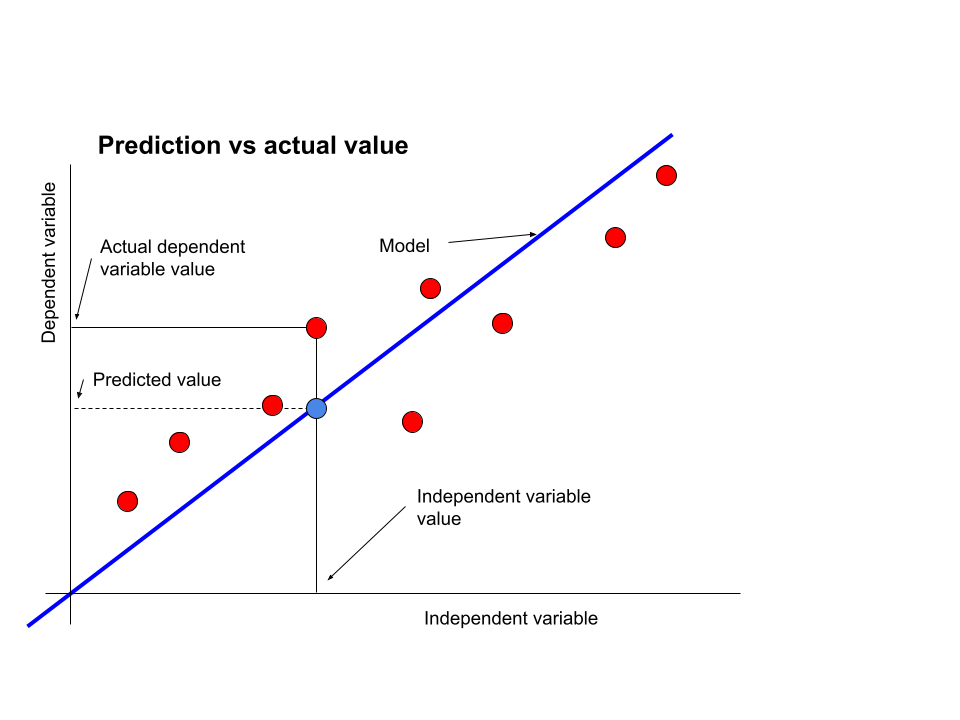

The next image shows the errors or residuals. The difference between the actual dependent variable value and the predicted value.

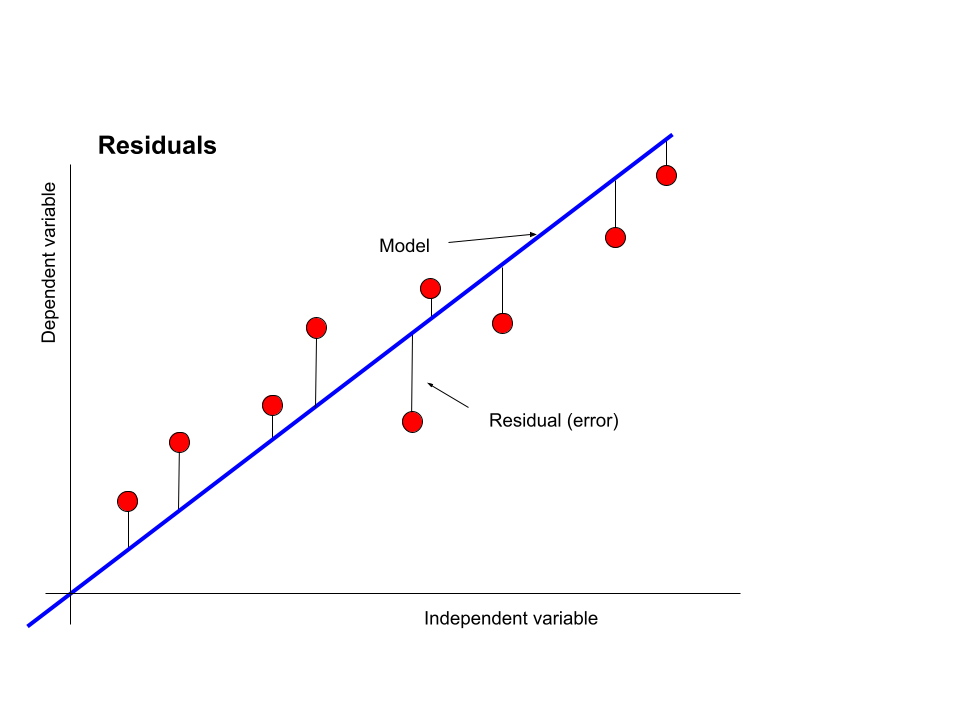

The generation of the model follows processes that aim to minimize the difference between the predictions and the actual values, by considering the sum of the square of the residuals.

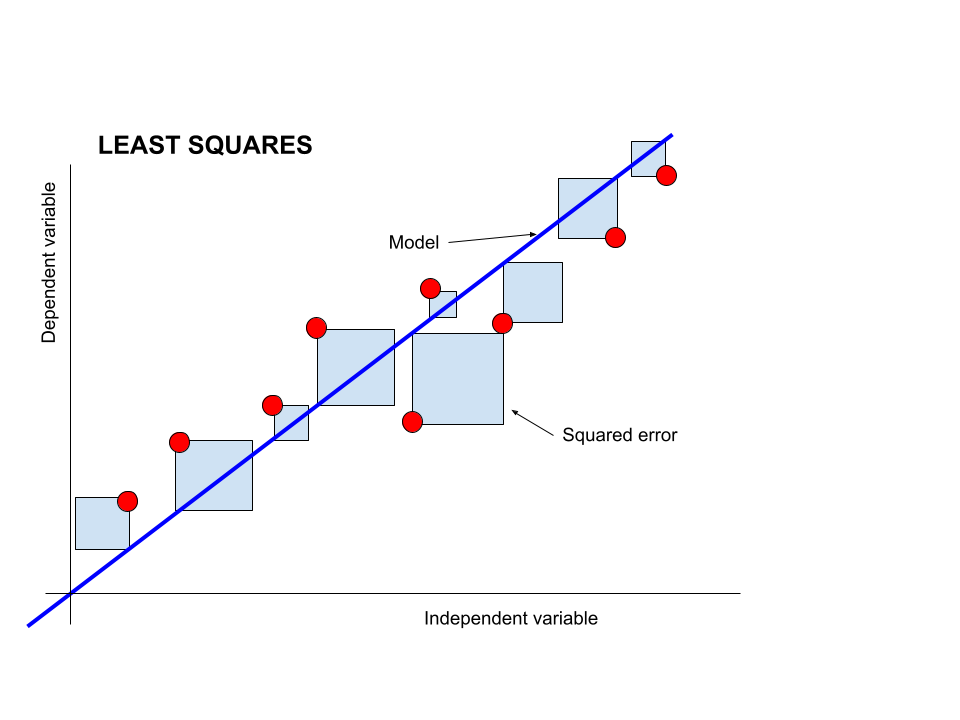

The residuals are squared to generate positive values. Some of the residuals are negative and some are positive. Simply adding them will result in a $0$.

There are various methods of determining the _parameters_ (the intercept $\beta_{0}$ and the slope $\beta_{1}$) of this model (blue line). One method is __ordinary least squares__. It involves the use of linear algebra. The matrix equation is shown below in (6). Here $A$ is our design matrix `X` from above and $\mathbf{y}$ is the vector of dependent variables. The $T$ refers to the transpose of a matrix and the $-1$ refers to the inverse of a matrix.

$$\mathbf{\beta} = {\left( A^{T} A \right)}^{-1} A^{T} \mathbf{y}  \tag{6}$$

We can also use calculus for the method of __gradient descent__ to find values for the parameters $\beta_{0}$ and $\beta_{1}$ that minimize a cost function.

These techniques are covered in more advanced courses.

Here, though, we evaluate how well this model achieved its aim of minimizing the errors, by way of calculating the __coefficient of determination__, shown in (7) below, where $s^{2}$ is the variance.

$$R^{2} = \frac{{s^{2}}_{\text{mean model residuals}} - {s^{2}}_{\text{best model residuals}}}{{s^{2}}_{\text{mean model residuals}}} \tag{7}$$

We see from (7) that we require two models, a __mean model__ and a __best model__. We will create these in the next section.

Note that equation (7) expresses the fraction of the variance in the dependent variable explained by the model. Below, we take a look at the mean model and the best fit model.

### MODEL BASED ON THE MEAN OF THE DEPENDENT VARIABLE

The simplest prediction of the dependent variable is its mean. Given any independent variable value, we simply use the mean of the dependent variable as predicted value.

In [ ]:
# Mean of the dependent variable
mean_dependent = np.mean(dependent)
mean_dependent

The model is represented as a line on the scatter plot below.

In [ ]:
go.Figure(
    data=(
        go.Scatter(
            x=df.Independent,
            y=df.Dependent,
            mode='markers',
            name='data',
            marker=dict(size=12)
        )
    )
).add_trace(
    go.Scatter(
        x=[80, 100],
        y=[mean_dependent, mean_dependent],
        mode='lines',
        name='mean model'
    )
).update_layout(
    title='Mean model',
    xaxis=dict(title='Independent variabe'),
    yaxis=dict(title='Dependent variable')
).show()

The first independent variable value on the scatter plot with the _mean model_ above is $80.5$. By the _mean model_, we predict a dependent variable value of $90.456$ (the mean of the dependent variable). The residual (difference between the dependent variable and the predicted variable is) $89 - 90.5 = -1.5$. We can calculate the residuals for all the observations.

As mentioned above, some will be negative residuals and some will be positive. Adding them will, by how we calculate the mean, be $0$. To solve this problem, we square each residual (squaring any value returns a positive value), giving us the variance in the dependent variable.

Below, we assign the variable to the computer variable `var_mean_model`.

In [ ]:
var_mean_model = np.var(dependent)
var_mean_model

Now for the best fit model. As mentioned, simple linear regression uses ordinary least squares or gradient descent to calculate a model that minimizes the residuals. Below, we use the stasmodels package's ordinary least squares method.

### `statsmodels` ORDINARY LEAST SQUARES

The `OLS` function of the statsmodels package calculates the best fit model. We pass the two design matrices from above and then call the `fit` method.

In [ ]:
linear_model = sm.OLS(y, X).fit()

We use the `summary2` function to look at the model.

In [ ]:
linear_model.summary2()

There is a lot of information here. In the middle of the summary, we see a table. The first column shows the coefficients of the model. The _y_ intercept (when $x=0$), which is the $\beta_{0}$ from before. The other is the slope of the best fit model, which is the $\beta_{1}$ from before. We add the line to the scatter plot of the data below.

In [ ]:
# Gerating x and y values for the line
x_vals = np.arange(80, 100, 0.1)
y_vals = 1.7253 + 0.9843 * x_vals

go.Figure(data=go.Scatter(x=independent, y=dependent,
    mode='markers',
    name='Data',
    marker=dict(size=12))).update_layout(title='Best fit model',
        yaxis=dict(title='Dependent variable'),
        xaxis=dict(title='Independent variable')).add_trace(go.Scatter(
            x=x_vals, y=y_vals,
            name='Best model',
            mode='lines'
        ))

We also note the $R^{2}$ value, the _F_ statistic, and the _p_ value for the _F_ statistic. We can understand more about them, by doing our own calculations. We start by looking at the residuals, an attribute of our model.

In [ ]:
# Residuals of best model
linear_model.resid

As an aside, given the design matrix of the independent variable, we can calculate the predicted values.

In [ ]:
# Model predictions given the data
linear_model.predict(X)

As with the _mean model_, we also calculate the variance in the residuals. It is assigned to the computer variable `var_best_model` below.

In [ ]:
# Sum of squared errors for the model
var_best_model = np.var(linear_model.resid)
var_best_model

We use equation (7) to recalculate the $R^{2}$ value.

In [ ]:
# R squared
(var_mean_model - var_best_model) / var_mean_model

This value will always be on the interval $\left[ 0,1 \right]$. Our model has a coefficient determination of $0.513$. We interpret this result by noting that our model (the independent variable) explains $51.3$% of the variance in the dependent variable.

### _p_ VALUE OF THE MODEL BASED ON THE _F_ STATISTIC

The _F_ distribution allows us to calculate a _p_ value for our model. The equation is shown in (8). Here, $\text{p}_{\text{best model}}$ and $\text{p}_{\text{mean model}}$ are the number of parameters in the best (fitted) and in the mean model, and $n$ is the number of observations. These calculations (as they appear in the numerator and denominator of equation (8)) are termed the __degrees of freedom__.

$$F = \frac{\frac{{s^{2}}_{\text{mean model residuals}} - {s^{2}}_{\text{best model residuals}}}{\text{p}_{\text{best model}}-{\text{p}}_{\text{mean model}}}}{\frac{{s^{2}}_{\text{mean model residuals}}}{n - {\text{p}}_{\text{best model}}}} \tag{8}$$

In [ ]:
p_best = 2 # Number of parameters in the fitted model
p_mean = 1 # Number of parameters in the model based on the mean
n = len(independent) # Sample size

In [ ]:
F = ((var_mean_model - var_best_model) / (p_best - p_mean)) / ((var_best_model) / (n - p_best))
F

Below, we calculate a _p_ value from the cumulative distribution function, `cdf`, for the _F_ distribution given the two degrees of freedom values in (8).

In [ ]:
# p value for the F statistic given the numerator and denominator degrees of freedom
1 - stats.f.cdf(F, p_best - p_mean, n - p_best)

### DIAGNOSTICS

There are underlying assumptions that must be met for the use of linear regression in this way. The model that we have built is linear and it might be that the relationship between the variables is not linear. This might become evident when plotting the residuals for each independent variable.

In [ ]:
residuals = linear_model.resid # The residuals

In [ ]:
go.Figure(data=go.Scatter(x=independent, y=residuals,
    mode='markers',
    name='Residuals',
    marker=dict(size=12))).update_layout(title='Residual plot',
        yaxis=dict(title='Residuals'),
        xaxis=dict(title='Independent variable')).add_trace(go.Scatter(
            x=[np.min(independent), np.max(independent)],
            y=[0, 0],
            name='Zero line',
            mode='lines'
        ))

We note a fairly even spread (above and below the zero line) of the residuals across the values for the independent variable. There does not seem to be a pattern in the spread, i.e. for some values of the independent variable most of the residuals are on one side of the zero line.

If there is no pattern or indication of non-linearity, we should see no correlation between the independent variable and the residuals.

In [ ]:
stats.pearsonr(
    independent,
    residuals
)

The correlation coefficient is $0$, indicating no correlation.

The residuals might also show a sideways pyramidal shape (being much higer and lower at one end of the independent variable scale and very close to the zero line as we move to the opposite side of the independent variable. This may indicate __heteroscedasticity__.

There is a relationship between the standard deviation of the residuals, $s_{\text{res}}$, and the standard deviation of the dependent variable, $s_{Y}$ , shown in (9). 

$$s_{\text{res}} = \sqrt{1 - r^{2}} \times s_{Y} \tag{9}$$

## MULTIVARIABLE LINEAR REGRESSION

We can add more independent variables to a linear regression model. A linear regression model with more than one independent variable is known as a __multivariable linear regression model__. Below we create two variables and a dependent variable and generate a pandas dataframe object from the results.

In [ ]:
# Generating numpy arrays with random values
var1 = np.random.randint(low=100, high=200, size=100) / 10
var2 = np.random.randn(100)
dependent = var1 + var2 + (np.random.randn(100) * 10)

# Add the arrays to a DataFrame object
df = DataFrame(
    {
        'Variable1':var1,
        'Variable2':var2,
        'Dependent':dependent
    }
)
df[:10]

Below we view a scatter plot consisting of the two independent variables on the _x_ and _y_ axes and then the dependent variable as a continuous color.

In [ ]:
go.Figure(
    data=go.Scatter(
        x=df.Variable1,
        y=df.Variable2,
        mode='markers',
        marker=dict(
            size=16,
            color=df.Dependent,
            colorscale='Viridis',
            showscale=True
        )
    )
).update_layout(title='Scatter plot of independent variables and heatmap as dependent variable')

We can also create a scatter plot of each pair of the three numerical variables.

In [ ]:
px.scatter_matrix(
    df,
    title='Scatter plot matrix'
)

We once again generate design matrices using the `dmatrices` function in the patsy package.

In [ ]:
y, X = dmatrices(
    'Dependent ~ Variable1 + Variable2',
    data = df
)

The matrix with predictor variables is shown below.

In [ ]:
X[:5]

The linear model is created just as before, using the `OLS` function in the statsmodels package. The model is assigned to the `multi_lin_model` computer variable.

In [ ]:
multi_lin_model = sm.OLS(y, X).fit()

In [ ]:
multi_lin_model.summary2()

The `multi_lin_model` object has a `resid` attribute (as before). We express the variance in the mean model (mean of the dependent variable) and in the residuals.

In [ ]:
var_mean_model = np.var(df.Dependent)
var_best_model = np.var(multi_lin_model.resid)

We can now use equation (7) the replicate the $R^{2}$ value.

In [ ]:
(var_mean_model - var_best_model) / var_mean_model 

We can also replicate the values for the _F_ statistic and the _p_ value. Our best model has $3$ parameters and the mean model still only $1$.

In [ ]:
p_best = 3
p_mean = 1
n = len(df.Dependent)

Below, we calculate the _F_ statistic and the _p_value.

In [ ]:
F = ((var_mean_model - var_best_model) / (p_best - p_mean)) / ((var_best_model) / (n - p_best))
F

In [ ]:
1 - stats.f.cdf(F, p_best - p_mean, n - p_best)

## REVISITING THE _t_ TEST

Instead of using Student's _t_ test, we can use the _F_ distribution when comparing two means. We start by generating two python list objects that contain our variable of interest. This represents the same statistical variable for two groups. Both groups of values are from a normal distribution, with a slight difference in mean and standard deviation.

In [ ]:
np.random.seed(7) # For reproducible results

groupI = np.random.normal(100, 5, 100)
groupII = np.random.normal(103, 8, 110)
groupAll = np.append(groupI, groupII)

A box plot of the distribution of the variable for each group visualizes the difference.

In [ ]:
go.Figure(
    data=go.Box(
        y=groupI,
        name='Group I'
    )
).add_trace(
    go.Box(
        y=groupII,
        name='GroupII'
    )
).update_layout(
    title='Distribution of variable in each group',
    xaxis=dict(title='Group'),
    yaxis=dict(title='Variable value')
)

### STUDENT'S _t_ TEST

The simplest way to compare the means is to use Student's _t_ test, `ttest_ind`, making use of the _t_ distribution and defined degrees of freedom.

In [ ]:
stats.ttest_ind(groupI, groupII)

Below instead, we use the _F_ distribution to recalculate the _p_ value.

### CALCULATING THE _F_ STATISTIC AND _p_ VALUE

We follow the same principles as we did with the simple linear regression model. Here, though, we only consider the sum of squared residuals (and not the variance and there are, or may be, a different number of samples in each group). Our simplest model would represent the sum of squared errors with respect to the mean of all the `Independent` variable values.

In [ ]:
# Sum of squared errors with the mean of all the values as model
ss_mean = np.sum((groupAll - np.mean(groupAll))**2)
ss_mean

We do the same for each of the two groups. This represents our best fit model.

In [ ]:
ss_I = np.sum((groupI - np.mean(groupI))**2)
ss_I

In [ ]:
ss_II = np.sum((groupII - np.mean(groupII))**2)
ss_II

Our best fit model sums the two sum of squared errors.

In [ ]:
ss_best = ss_I + ss_II
ss_best

The number of parameters in the simple (mean) model is just $1$. There are $2$ means in the best fit model.

In [ ]:
# Degrees of freedom for the two models
p_best = 2
p_mean = 1
n = len(groupAll)

We now calculate the _F_ statistic using equation (10).

$$F = \frac{\frac{\text{SS}_{\text{mean model}} - {\text{SS}}_{\text{best model}}}{{\text{p}}_{\text{best model}}-{\text{p}}_{\text{mean model}}}}{\frac{{\text{SS}}_{\text{best model}}}{n - {\text{p}}_{\text{best model}}}} \tag{10}$$

In [ ]:
F = ((ss_mean - ss_best) / (p_best - p_mean)) / ((ss_best) / (n - p_best))
F

It is left to use the cumulative distribution function for the _F_ distribution given the degrees of freedom in the numerator and the denominator.

In [ ]:
1 - stats.f.cdf(F, p_best - p_mean, n - p_best)

This is the same value as calculated using Student's _t_ test.

## ANALYSIS OF VARIANCE

We can also compare more than two groups using analysis of variance (ANOVA). Below, we create a dataframe object with a categorical variable consisting of three sample space elements (generating our three groups) and a numerical variable.

In [ ]:
np.random.seed(123)
df = DataFrame(
    {'Group':np.random.choice(['A', 'B', 'C'], size=300, replace=True),
    'Variable':np.random.randn(300)})

In [ ]:
df[:10] # First 10 observations

Below, we extract three numpy arrays for the numerical variable, one for each of the sample space elements of the categorical variable.

In [ ]:
groupA = df[df.Group == 'A'].Variable.to_numpy()
groupB = df[df.Group == 'B'].Variable.to_numpy()
groupC = df[df.Group == 'C'].Variable.to_numpy()

We view the summary statistics of the three groups with respect to the numerical variable.

In [ ]:
df.groupby('Group')['Variable'].describe()

A box plot shows the differences in the distribution of the numerical variable for the three groups.

In [ ]:
px.box(
    df,
    x='Group',
    y='Variable',
    title='Variable by group')

### ANOVA

The `f_oneway` function in the scipy stats package can calculate the _p_ for us.

In [ ]:
stats.f_oneway(
    groupA,
    groupB,
    groupC
)

We fail to reject the null hypothesis (there are no difference in the means of the variable for the three groups.) We can recalculate the _F_ statistic and the _p_ value as before.

### CALCULATING THE _F_ STATISTIC AND _p_ VALUE

The sum of squared errors for the mean model is calculated first.

In [ ]:
ss_mean = np.sum((df.Variable - np.mean(df.Variable))**2)
ss_mean

The sum of squared errors around the individual means are calculated next.

In [ ]:
ss_a = np.sum((groupA - np.mean(groupA))**2)
ss_b = np.sum((groupB - np.mean(groupB))**2)
ss_c = np.sum((groupC - np.mean(groupC))**2)

Our best model adds these errors.

In [ ]:
ss_best = ss_a + ss_b + ss_c
ss_best

The mean model has a single parameter and the best model has $3$ (means).

In [ ]:
p_mean = 1
p_best = 3
n = len(df.Variable)

Below, we complete the recalculation of the _F_ statistic and the _p_ value.

In [ ]:
F = ((ss_mean - ss_best) / (p_best - p_mean)) / ((ss_best) / (n - p_best))
F

In [ ]:
1 - stats.f.cdf(F, p_best - p_mean, n - p_best)

## CONCLUSION

Understanding mean models, variance, the best fitted model, residuals, and model parameter numbers, we can use the _F_ distribution to great effect.